# **GAN Deeplearning Model - Image generation**

# **Install libraries**

In [ ]:
!pip install torch torchvision matplotlib numpy pillow

# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np


# **Import Data Set (anime face data set)**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

dataset = datasets.ImageFolder(root=path,
                               transform=transforms.Compose([
                                   transforms.Resize(64),
                                   transforms.CenterCrop(64),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 395M/395M [00:14<00:00, 29.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


# **Define the GAN Architecture**

# **Generator - Creates fake anime images.**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 3, 64, 64)  # Reshape to image format


# **Discriminator – Distinguishes real images from fake ones.**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64*64*3, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 64*64*3)  # Flatten input
        return self.model(x)


# **Train the GAN**

Epoch [1/100] | D Loss: 0.10355505347251892 | G Loss: 8.97457504272461


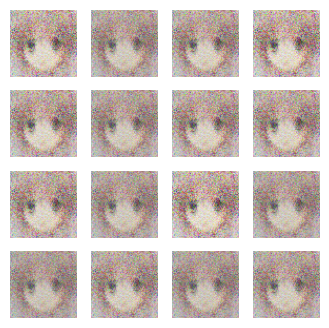

Epoch [2/100] | D Loss: 0.5438298583030701 | G Loss: 3.989132881164551
Epoch [3/100] | D Loss: 2.0680575370788574 | G Loss: 1.5376542806625366
Epoch [4/100] | D Loss: 0.046883564442396164 | G Loss: 3.9422388076782227
Epoch [5/100] | D Loss: 0.05032995715737343 | G Loss: 3.931244134902954
Epoch [6/100] | D Loss: 0.15397793054580688 | G Loss: 4.012215614318848
Epoch [7/100] | D Loss: 0.25669538974761963 | G Loss: 5.30763053894043


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

num_epochs = 100
for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        real_loss = criterion(D(real_images), real_labels)

        noise = torch.randn(real_images.size(0), 100).to(device)
        fake_images = G(noise)
        fake_loss = criterion(D(fake_images.detach()), fake_labels)

        D_loss = real_loss + fake_loss
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_loss = criterion(D(fake_images), real_labels)
        fake_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {D_loss.item()} | G Loss: {fake_loss.item()}")

    if epoch % 10 == 0:
        with torch.no_grad():
            sample = G(torch.randn(16, 100).to(device))
            sample = sample.cpu().numpy().transpose(0, 2, 3, 1)
            sample = (sample + 1) / 2  # Rescale to [0,1]
            plt.figure(figsize=(4,4))
            for i in range(16):
                plt.subplot(4, 4, i+1)
                plt.imshow(sample[i])
                plt.axis("off")
            plt.show()
